In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for statistical data visualization
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, precision_score, roc_curve, auc,roc_auc_score
import itertools
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from scipy.stats import randint, uniform

In [7]:
#read dataset
data='/content/CSRF_dataset.csv'
df= pd.read_csv(data)

In [8]:
print(f"Number of Rows: {df.shape[0]}")
print(f"Number of Columns: {df.shape[1]}")

Number of Rows: 5894
Number of Columns: 52


In [9]:
X = df.drop(['flag'], axis=1)
y = df['flag']

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [11]:
train_counts = y_train.value_counts()
print("Train set counts:")
print(train_counts)

Train set counts:
flag
0    3967
1     748
Name: count, dtype: int64


**As we notice, the train set is imbalance so we'll use SMOT module to do "resampling" operation and make it more balanced**      
**Plese note that we'll apply resampling only on Train set and we won't apply it on test set, this is to train model better but test it in more realistic way on a data that really reflects the real-world case.**

In [12]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [13]:
print("Train set counts after SMOTE:")
print(y_train_res.value_counts())

Train set counts after SMOTE:
flag
0    3967
1    3967
Name: count, dtype: int64


In [14]:
test_counts = y_test.value_counts()
print("Test set counts:")
print(test_counts)

Test set counts:
flag
0    995
1    184
Name: count, dtype: int64


In [15]:
print("X_train:", X_train_res.shape)
print("y_train:", y_train_res.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (7934, 51)
y_train: (7934,)
X_test: (1179, 51)
y_test: (1179,)


---
# Functions to give reports about models

In [16]:
y_train_pred, y_test_pred = None, None
def evaluate_model (model) :
    global y_train_pred, y_test_pred
    y_train_pred = model.predict(X_train_res)
    y_test_pred = model.predict(X_test)

In [17]:
def show_confusion_matrix ():
    cm_train = confusion_matrix(y_train_res, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)

    # Plot confusion matrix
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cm_train, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - Training')
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_train)))
    plt.xticks(tick_marks, np.unique(y_train))
    plt.yticks(tick_marks, np.unique(y_train))
    fmt = 'd'
    thresh = cm_train.max() / 2.
    for i, j in itertools.product(range(cm_train.shape[0]), range(cm_train.shape[1])):
        plt.text(j, i, format(cm_train[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm_train[i, j] > thresh else "black")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.subplot(1, 2, 2)
    plt.imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - Testing')
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_test)))
    plt.xticks(tick_marks, np.unique(y_test))
    plt.yticks(tick_marks, np.unique(y_test))
    fmt = 'd'
    thresh = cm_test.max() / 2.
    for i, j in itertools.product(range(cm_test.shape[0]), range(cm_test.shape[1])):
        plt.text(j, i, format(cm_test[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm_test[i, j] > thresh else "black")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.tight_layout()
    plt.show()

In [18]:
from sklearn.metrics import classification_report, roc_auc_score

def get_classification_report():
    # Calculate predicted probabilities for training and testing sets
    y_train_pred_proba = dt_grid_search.best_estimator_.predict_proba(X_train_res)[:, 1]
    y_test_pred_proba = dt_grid_search.best_estimator_.predict_proba(X_test)[:, 1]

    # Convert predicted probabilities to binary predictions for classification report
    y_train_pred = (y_train_pred_proba >= 0.5).astype(int)
    y_test_pred = (y_test_pred_proba >= 0.5).astype(int)

    # Calculate ROC AUC score for training and testing
    roc_auc_train = roc_auc_score(y_train_res, y_train_pred_proba)
    roc_auc_test = roc_auc_score(y_test, y_test_pred_proba)

    cr_train = classification_report(y_train_res, y_train_pred, output_dict=True)
    cr_test = classification_report(y_test, y_test_pred, output_dict=True)

    metrics = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC'],
        'Train': [cr_train['accuracy'], cr_train['1']['precision'], cr_train['1']['recall'], cr_train['1']['f1-score'], roc_auc_train],
        'Test': [cr_test['accuracy'], cr_test['1']['precision'], cr_test['1']['recall'], cr_test['1']['f1-score'], roc_auc_test]
    }
    metrics_df = pd.DataFrame(metrics)
    return metrics_df

In [19]:
def show_roc_curve(model):
    # Plot ROC curve and calculate AUC
    y_train_proba = model.predict_proba(X_train_res)[:,1]
    y_test_proba = model.predict_proba(X_test)[:,1]

    fpr_train, tpr_train, _ = roc_curve(y_train_res, y_train_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

    auc_train = auc(fpr_train, tpr_train)
    auc_test = auc(fpr_test, tpr_test)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, label=f'Train AUC = {auc_train:.2f}')
    plt.plot(fpr_test, tpr_test, label=f'Test AUC = {auc_test:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

In [20]:
roc_auc_scorer = make_scorer(roc_auc_score, average='weighted', multi_class='ovr')

---
# Decision tree

### Most important hyperparameters that we have to deal with :
#### 1. criterion: Criterion for selecting features testing order. (This may change features testing order => Change tree structure)
#### 2. max_depth: Maximim depth of the tree. (More depth => More complex model)
#### 3. min_samples_split: Minimum number of samples in a node to split it. (Lower values => Higher overfitting risk)
#### 4. min_samples_leaf: Minimum allowed number of samples in each leaf node (Lower values => Higher overfitting risk)

**Training a decision tree model using Gini impurity as the criterion**


In [21]:
#DT = DecisionTreeClassifier()

In [22]:
#DT.fit(X_train_res, y_train_res)
#evaluate_model(DT)
#get_classification_report()

#### As we notice, we have a perfect model on training set, but bad results on testing set => Let's tune hyperparameters to avoid overfitting and make the model more stable.

**Training a decision tree model using Entropy as the criterion**

In [23]:
#DTE = DecisionTreeClassifier(criterion="entropy")

In [24]:
#DTE.fit(X_train_res, y_train_res)
#evaluate_model(DTE)
#get_classification_report()

#### The model still suffers overfitting

**CV=5**

In [25]:
# Define parameters for grid search
parameters = {
    'max_depth': [2,5,10,15,18,23],
    'min_samples_leaf': [2,8,10,15,20,25,30],
    'min_samples_split': [2,4,8,12,20,25,35],
    'criterion': ['gini', 'entropy'],
}

# Initialize the Decision Tree Classifier with possible parameters for tuning
dt_grid_search = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5, scoring=roc_auc_scorer, n_jobs=-1)
dt_grid_search.fit(X_train_res, y_train_res)

# Best parameters found
print(f'Best parameters: {dt_grid_search.best_params_}')

# Calculate ROC AUC on training set
y_pred_train = dt_grid_search.best_estimator_.predict_proba(X_train_res)[:, 1]
roc_auc_train = roc_auc_score(y_train_res, y_pred_train)
print("ROC AUC score on training set: ", roc_auc_train)

# Calculate ROC AUC on testing set
y_pred_test = dt_grid_search.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_test)
print("ROC AUC score on testing set: ", roc_auc_test)

Best parameters: {'criterion': 'gini', 'max_depth': 23, 'min_samples_leaf': 2, 'min_samples_split': 4}
ROC AUC score on training set:  0.9973801063208069
ROC AUC score on testing set:  0.8296810137644746


In [26]:
dt_model = dt_grid_search.best_estimator_
evaluate_model(dt_model)

In [27]:
get_classification_report()

,Metric,Train,Test
0,Accuracy,0.970885,0.855810
1,Precision,0.949471,0.526923
2,Recall,0.994706,0.744565
3,F1-score,0.971562,0.617117
4,ROC AUC,0.997380,0.829681


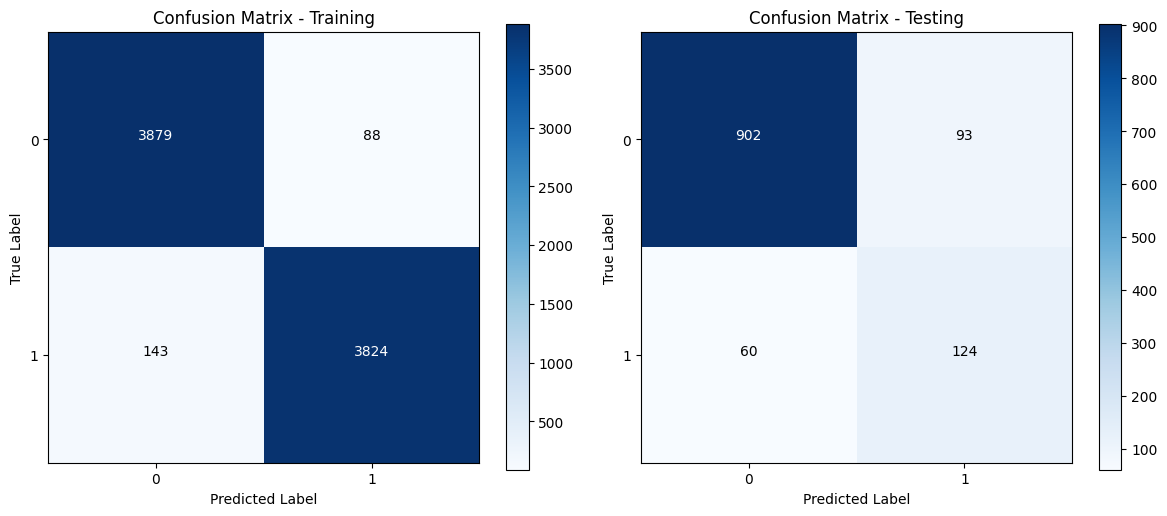

In [28]:
show_confusion_matrix()

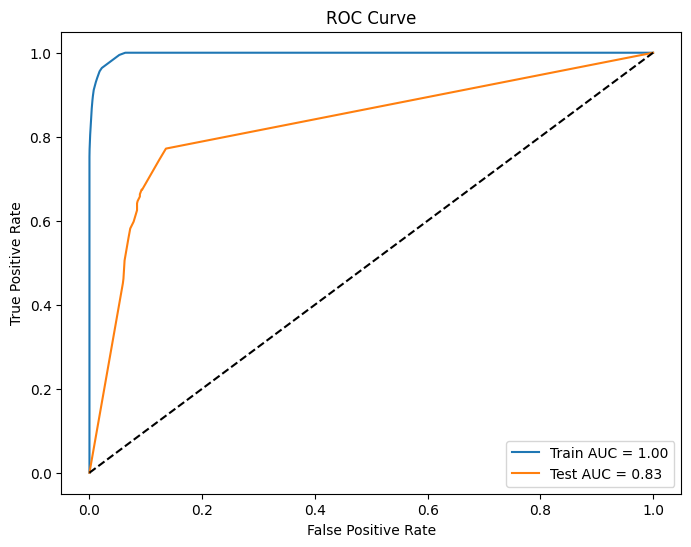

In [29]:
show_roc_curve(dt_model)

In [31]:
# Define parameters for grid search
parameters = {
    'max_depth': [x for x in range(10, 30)],# ulist of values from 1 to 10
    'min_samples_leaf': [x for x in range(5,15)],
    'min_samples_split': [x for x in range(3, 15)],
    'criterion': ['gini', 'entropy'],
}

# Initialize the Decision Tree Classifier with possible parameters for tuning
dt_grid_search = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5, scoring=roc_auc_scorer, n_jobs=-1)
dt_grid_search.fit(X_train_res, y_train_res)

# Best parameters found
print(f'Best parameters: {dt_grid_search.best_params_}')

# Calculate ROC AUC on training set
y_pred_train = dt_grid_search.best_estimator_.predict_proba(X_train_res)[:, 1]
roc_auc_train = roc_auc_score(y_train_res, y_pred_train)
print("ROC AUC score on training set: ", roc_auc_train)

# Calculate ROC AUC on testing setn
y_pred_test = dt_grid_search.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_test)
print("ROC AUC score on testing set: ", roc_auc_test)

Best parameters: {'criterion': 'gini', 'max_depth': 23, 'min_samples_leaf': 5, 'min_samples_split': 3}
ROC AUC score on training set:  0.992845976787702
ROC AUC score on testing set:  0.8680904522613063


In [32]:
# Define parameters for grid search
parameters = {
    'max_depth': [x for x in range(1, 20)],# ulist of values from 1 to 10
    'min_samples_leaf': [x for x in range(15,35)],
    'min_samples_split': [x for x in range(10,30)],
    'criterion': ['gini', 'entropy'],
}

# Initialize the Decision Tree Classifier with possible parameters for tuning
dt_grid_search = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5, scoring=roc_auc_scorer, n_jobs=-1)
dt_grid_search.fit(X_train_res, y_train_res)

# Best parameters found
print(f'Best parameters: {dt_grid_search.best_params_}')

# Calculate ROC AUC on training set
y_pred_train = dt_grid_search.best_estimator_.predict_proba(X_train_res)[:, 1]
roc_auc_train = roc_auc_score(y_train_res, y_pred_train)
print("ROC AUC score on training set: ", roc_auc_train)

# Calculate ROC AUC on testing setn
y_pred_test = dt_grid_search.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_test)
print("ROC AUC score on testing set: ", roc_auc_test)

Best parameters: {'criterion': 'gini', 'max_depth': 17, 'min_samples_leaf': 15, 'min_samples_split': 18}
ROC AUC score on training set:  0.9770939847896901
ROC AUC score on testing set:  0.8887317019882017


In [35]:
# Define parameters for grid search
parameters = {
    'max_depth': [x for x in range(1, 20)],# ulist of values from 1 to 10
    'min_samples_leaf': [x for x in range(5,20)],
    'min_samples_split': [x for x in range(20,45)],
    'criterion': ['gini', 'entropy'],
}

# Initialize the Decision Tree Classifier with possible parameters for tuning
dt_grid_search = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5, scoring=roc_auc_scorer, n_jobs=-1)
dt_grid_search.fit(X_train_res, y_train_res)

# Best parameters found
print(f'Best parameters: {dt_grid_search.best_params_}')

# Calculate ROC AUC on training set
y_pred_train = dt_grid_search.best_estimator_.predict_proba(X_train_res)[:, 1]
roc_auc_train = roc_auc_score(y_train_res, y_pred_train)
print("ROC AUC score on training set: ", roc_auc_train)

# Calculate ROC AUC on testing setn
y_pred_test = dt_grid_search.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_test)
print("ROC AUC score on testing set: ", roc_auc_test)

Best parameters: {'criterion': 'entropy', 'max_depth': 19, 'min_samples_leaf': 5, 'min_samples_split': 21}
ROC AUC score on training set:  0.9891872632861134
ROC AUC score on testing set:  0.8760132182652393


In [36]:
# Define parameters for grid search
parameters = {
    'max_depth': [x for x in range(1, 10)],# ulist of values from 1 to 10
    'min_samples_leaf': [x for x in range(20,25)],
    'min_samples_split': [x for x in range(20,35)],
    'criterion': ['gini', 'entropy'],
}

# Initialize the Decision Tree Classifier with possible parameters for tuning
dt_grid_search = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5, scoring=roc_auc_scorer, n_jobs=-1)
dt_grid_search.fit(X_train_res, y_train_res)

# Best parameters found
print(f'Best parameters: {dt_grid_search.best_params_}')

# Calculate ROC AUC on training set
y_pred_train = dt_grid_search.best_estimator_.predict_proba(X_train_res)[:, 1]
roc_auc_train = roc_auc_score(y_train_res, y_pred_train)
print("ROC AUC score on training set: ", roc_auc_train)

# Calculate ROC AUC on testing setn
y_pred_test = dt_grid_search.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_test)
print("ROC AUC score on testing set: ", roc_auc_test)

Best parameters: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 21, 'min_samples_split': 20}
ROC AUC score on training set:  0.9483210331974357
ROC AUC score on testing set:  0.8774115140922002


In [37]:
dt_model = dt_grid_search.best_estimator_
evaluate_model(dt_model)

In [38]:
get_classification_report()

,Metric,Train,Test
0,Accuracy,0.899546,0.819338
1,Precision,0.873997,0.454545
2,Recall,0.933703,0.788043
3,F1-score,0.902864,0.576541
4,ROC AUC,0.948321,0.877412


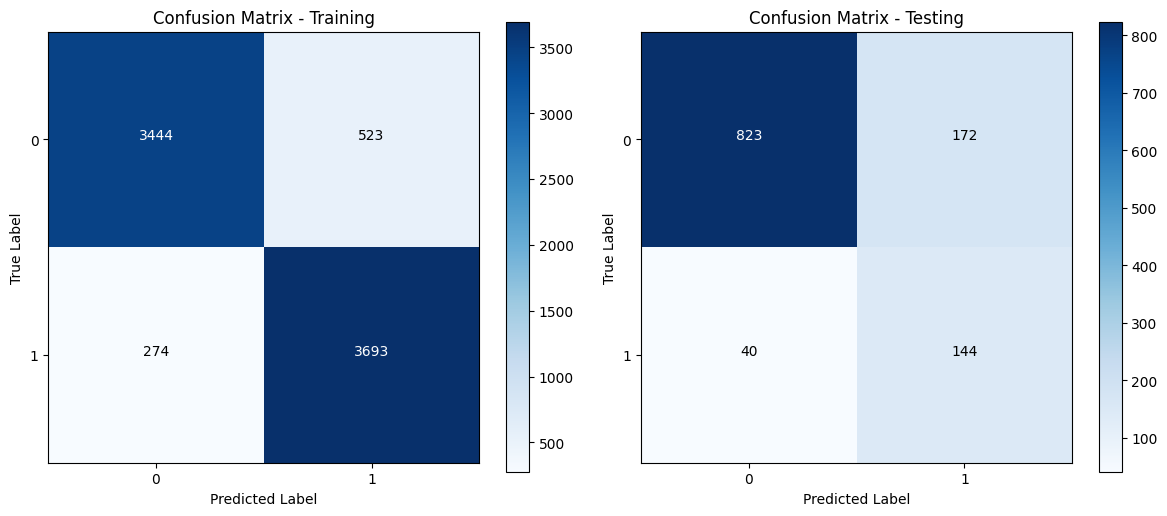

In [39]:
show_confusion_matrix()

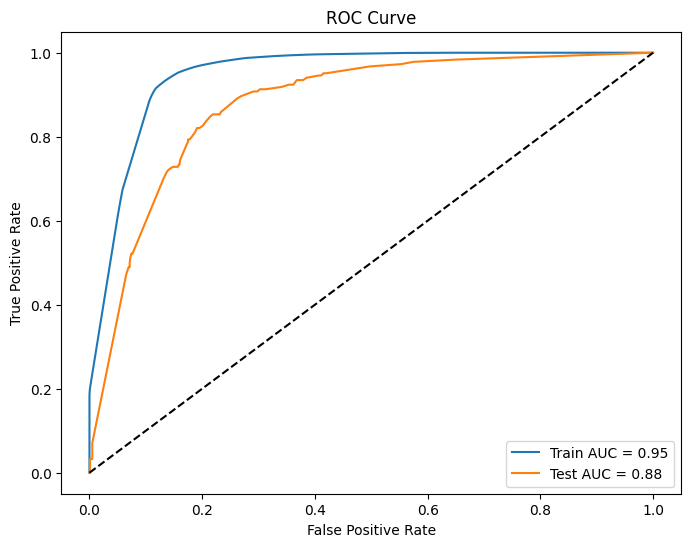

In [40]:
show_roc_curve(dt_model)

**CV=10**

In [41]:
# Define parameters for grid search
parameters = {
    'max_depth': [x for x in range(5, 16)],# ulist of values from 1 to 10
    'min_samples_leaf': [x for x in range(2,20)],
    'min_samples_split': [x for x in range(2, 30)],
    'criterion': ['gini', 'entropy'],
}

# Initialize the Decision Tree Classifier with possible parameters for tuning
dt_grid_search =GridSearchCV(DecisionTreeClassifier(), parameters, cv=10, scoring=roc_auc_scorer, n_jobs=-1)
dt_grid_search.fit(X_train_res, y_train_res)

# Best parameters found
print(f'Best parameters: {dt_grid_search.best_params_}')
# Calculate ROC AUC on training set
y_pred_train = dt_grid_search.best_estimator_.predict_proba(X_train_res)[:, 1]
roc_auc_train = roc_auc_score(y_train_res, y_pred_train)
print("ROC AUC score on training set: ", roc_auc_train)

# Calculate ROC AUC on testing setn
y_pred_test = dt_grid_search.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_test)
print("ROC AUC score on testing set: ", roc_auc_test)

Best parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5}
ROC AUC score on training set:  0.9900966118956308
ROC AUC score on testing set:  0.8444559755298229


In [42]:
dt_model = dt_grid_search.best_estimator_
evaluate_model(dt_model)

In [43]:
get_classification_report()

,Metric,Train,Test
0,Accuracy,0.954122,0.852417
1,Precision,0.931497,0.518248
2,Recall,0.980338,0.771739
3,F1-score,0.955294,0.620087
4,ROC AUC,0.990097,0.844456


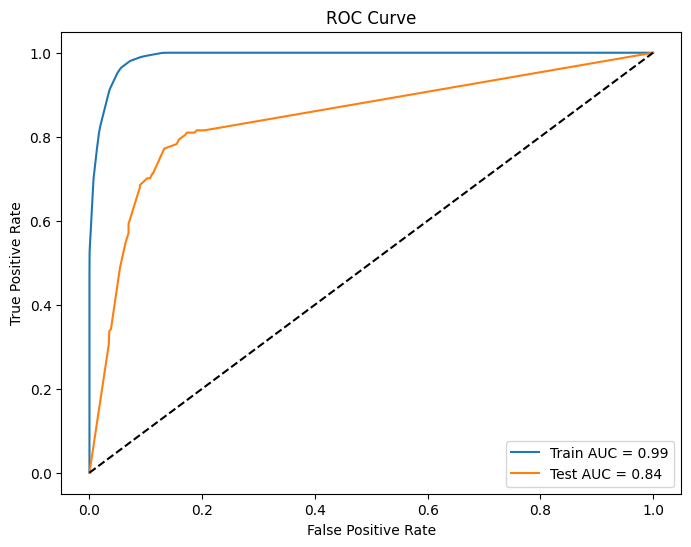

In [44]:
show_roc_curve(dt_model)

In [45]:
# Define parameters for grid search
parameters = {
    'max_depth': [x for x in range(1, 10)],# list of values from 1 to 10
    'min_samples_leaf': [20,24,26,30],
    'min_samples_split': [20,28,30,34,36],
    'criterion': ['gini', 'entropy'],
}

# Initialize the Decision Tree Classifier with possible parameters for tuning
dt_grid_search =GridSearchCV(DecisionTreeClassifier(), parameters, cv=10, scoring=roc_auc_scorer, n_jobs=-1)
dt_grid_search.fit(X_train_res, y_train_res)

# Best parameters found
print(f'Best parameters: {dt_grid_search.best_params_}')
# Calculate ROC AUC on training set
y_pred_train = dt_grid_search.best_estimator_.predict_proba(X_train_res)[:, 1]
roc_auc_train = roc_auc_score(y_train_res, y_pred_train)
print("ROC AUC score on training set: ", roc_auc_train)

# Calculate ROC AUC on testing setn
y_pred_test = dt_grid_search.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_test)
print("ROC AUC score on testing set: ", roc_auc_test)

Best parameters: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 24, 'min_samples_split': 20}
ROC AUC score on training set:  0.9477385557138299
ROC AUC score on testing set:  0.8768024907144417


In [46]:
dt_model = dt_grid_search.best_estimator_
evaluate_model(dt_model)

In [47]:
get_classification_report()

,Metric,Train,Test
0,Accuracy,0.897656,0.812553
1,Precision,0.867288,0.443425
2,Recall,0.938997,0.788043
3,F1-score,0.901719,0.567515
4,ROC AUC,0.947739,0.876802


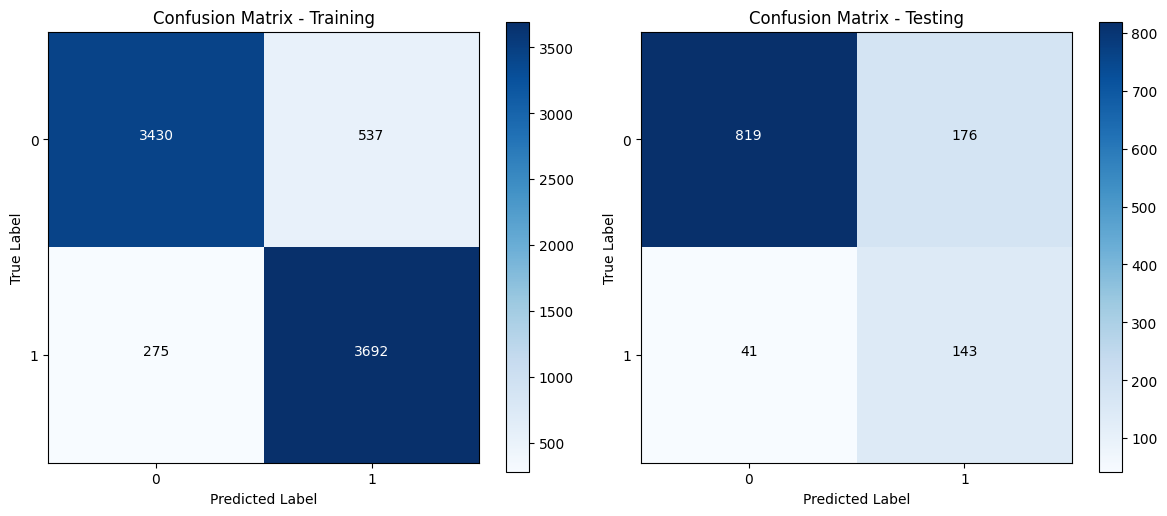

In [48]:
show_confusion_matrix()

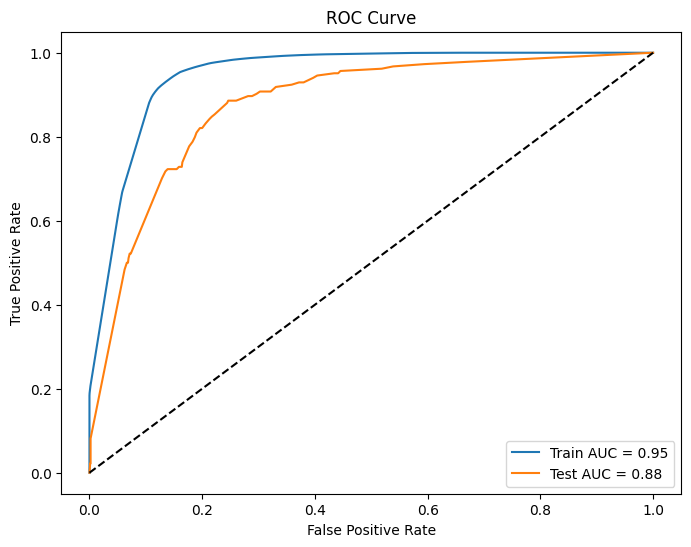

In [49]:
show_roc_curve(dt_model)

In [50]:
# Define parameters for grid search
parameters = {
    'max_depth': [7,8,9,10,11,12],# list of values from 1 to 10
    'min_samples_leaf': [20,22,23,25,27],
    'min_samples_split': [18,19,20,22,23],
    'criterion': ['gini', 'entropy'],
}

# Initialize the Decision Tree Classifier with possible parameters for tuning
dt_grid_search =GridSearchCV(DecisionTreeClassifier(), parameters, cv=10, scoring=roc_auc_scorer, n_jobs=-1)
dt_grid_search.fit(X_train_res, y_train_res)

# Best parameters found
print(f'Best parameters: {dt_grid_search.best_params_}')
# Calculate ROC AUC on training set
y_pred_train = dt_grid_search.best_estimator_.predict_proba(X_train_res)[:, 1]
roc_auc_train = roc_auc_score(y_train_res, y_pred_train)
print("ROC AUC score on training set: ", roc_auc_train)

# Calculate ROC AUC on testing setn
y_pred_test = dt_grid_search.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_test)
print("ROC AUC score on testing set: ", roc_auc_test)

Best parameters: {'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 22, 'min_samples_split': 19}
ROC AUC score on training set:  0.9641868963186268
ROC AUC score on testing set:  0.8904522613065327


In [51]:
# Define parameters for grid search
parameters = {
    'max_depth': [5,6,8],# list of values from 1 to 10
    'min_samples_leaf': [11,15,17,20],
    'min_samples_split': [15,18,20],
    'criterion': ['gini', 'entropy'],
}

# Initialize the Decision Tree Classifier with possible parameters for tuning
dt_grid_search =GridSearchCV(DecisionTreeClassifier(), parameters, cv=10, scoring=roc_auc_scorer, n_jobs=-1)
dt_grid_search.fit(X_train_res, y_train_res)

# Best parameters found
print(f'Best parameters: {dt_grid_search.best_params_}')
# Calculate ROC AUC on training set
y_pred_train = dt_grid_search.best_estimator_.predict_proba(X_train_res)[:, 1]
roc_auc_train = roc_auc_score(y_train_res, y_pred_train)
print("ROC AUC score on training set: ", roc_auc_train)

# Calculate ROC AUC on testing setn
y_pred_test = dt_grid_search.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_test)
print("ROC AUC score on testing set: ", roc_auc_test)

Best parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 11, 'min_samples_split': 20}
ROC AUC score on training set:  0.9432331799102109
ROC AUC score on testing set:  0.8743909766222416


In [52]:
# Define parameters for grid search
parameters = {
    'max_depth': [11,12],# list of values from 1 to 10
    'min_samples_leaf': [20,21,22,23],
    'min_samples_split': [17,18,19,20],
    'criterion': ['gini', 'entropy'],
}

# Initialize the Decision Tree Classifier with possible parameters for tuning
dt_grid_search =GridSearchCV(DecisionTreeClassifier(), parameters, cv=10, scoring=roc_auc_scorer, n_jobs=-1)
dt_grid_search.fit(X_train_res, y_train_res)

# Best parameters found
print(f'Best parameters: {dt_grid_search.best_params_}')
# Calculate ROC AUC on training set
y_pred_train = dt_grid_search.best_estimator_.predict_proba(X_train_res)[:, 1]
roc_auc_train = roc_auc_score(y_train_res, y_pred_train)
print("ROC AUC score on training set: ", roc_auc_train)

# Calculate ROC AUC on testing setn
y_pred_test = dt_grid_search.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_test)
print("ROC AUC score on testing set: ", roc_auc_test)

Best parameters: {'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 22, 'min_samples_split': 18}
ROC AUC score on training set:  0.9641868963186268
ROC AUC score on testing set:  0.8904522613065327


In [54]:
# Define parameters for grid search
parameters = {
    'max_depth': [8],# list of values from 1 to 10
    'min_samples_leaf': [5,6,7,8],
    'min_samples_split': [35,36,37,38,39],
    'criterion': ['gini', 'entropy'],
}

# Initialize the Decision Tree Classifier with possible parameters for tuning
dt_grid_search =GridSearchCV(DecisionTreeClassifier(), parameters, cv=10, scoring=roc_auc_scorer, n_jobs=-1)
dt_grid_search.fit(X_train_res, y_train_res)

# Best parameters found
print(f'Best parameters: {dt_grid_search.best_params_}')
# Calculate ROC AUC on training set
y_pred_train = dt_grid_search.best_estimator_.predict_proba(X_train_res)[:, 1]
roc_auc_train = roc_auc_score(y_train_res, y_pred_train)
print("ROC AUC score on training set: ", roc_auc_train)

# Calculate ROC AUC on testing setn
y_pred_test = dt_grid_search.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_test)
print("ROC AUC score on testing set: ", roc_auc_test)

Best parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 36}
ROC AUC score on training set:  0.9421594108033576
ROC AUC score on testing set:  0.8832395674022285


**we find the best model**


In [63]:
dt_model = dt_grid_search.best_estimator_
evaluate_model(dt_model)

In [64]:
get_classification_report()

,Metric,Train,Test
0,Accuracy,0.889211,0.817642
1,Precision,0.861254,0.454006
2,Recall,0.927905,0.831522
3,F1-score,0.893338,0.587332
4,ROC AUC,0.942159,0.883240


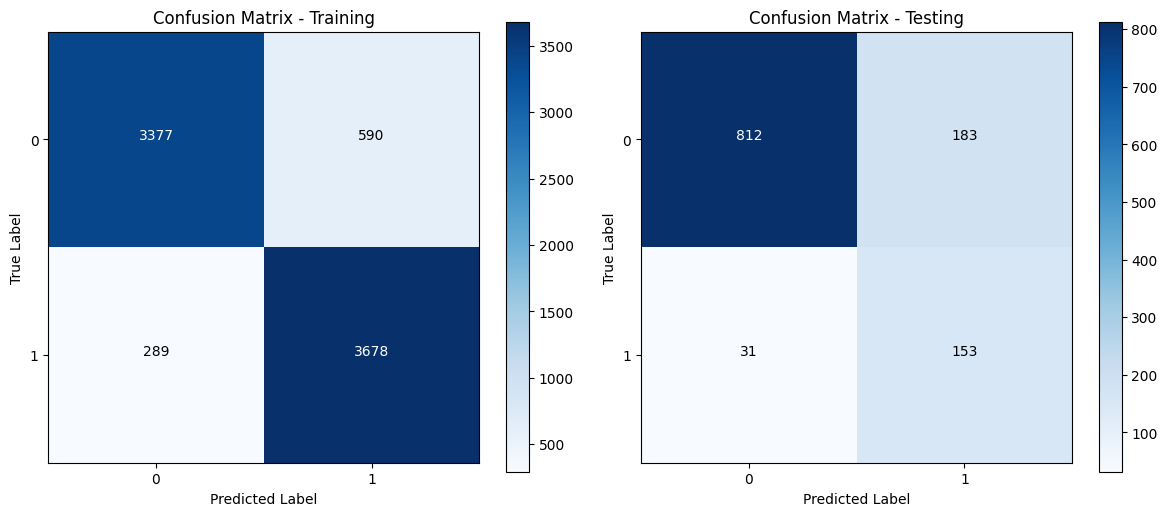

In [65]:
show_confusion_matrix()

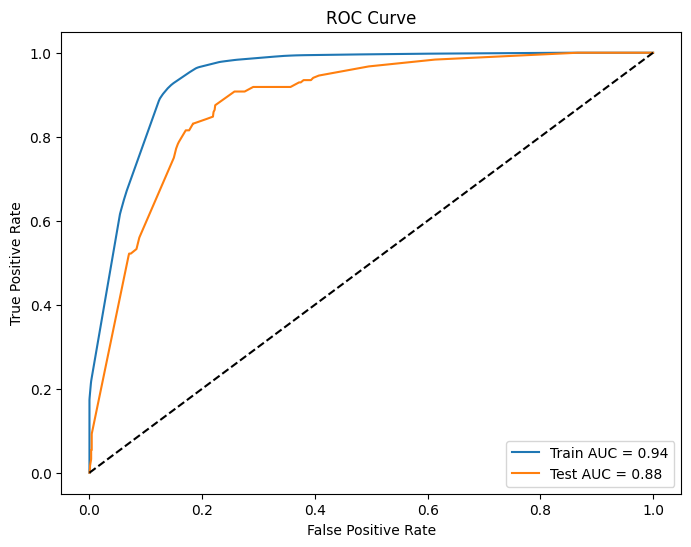

In [66]:
show_roc_curve(dt_model)

[Text(0.584478021978022, 0.95, 'x[49] <= 0.5\ngini = 0.5\nsamples = 7934\nvalue = [3967, 3967]'),
 Text(0.42788461538461536, 0.85, 'x[29] <= 0.5\ngini = 0.415\nsamples = 5367\nvalue = [1578, 3789]'),
 Text(0.3173076923076923, 0.75, 'x[3] <= 550.0\ngini = 0.38\nsamples = 5081\nvalue = [1294, 3787]'),
 Text(0.1813186813186813, 0.65, 'x[50] <= 0.5\ngini = 0.319\nsamples = 4210\nvalue = [840, 3370]'),
 Text(0.10989010989010989, 0.55, 'x[48] <= 0.5\ngini = 0.291\nsamples = 4083\nvalue = [721, 3362]'),
 Text(0.054945054945054944, 0.45, 'x[3] <= 0.5\ngini = 0.013\nsamples = 753\nvalue = [5, 748]'),
 Text(0.03296703296703297, 0.35, 'x[0] <= 6448.5\ngini = 0.081\nsamples = 95\nvalue = [4, 91]'),
 Text(0.02197802197802198, 0.25, 'x[0] <= 1545.0\ngini = 0.153\nsamples = 48\nvalue = [4, 44]'),
 Text(0.01098901098901099, 0.15, 'gini = 0.153\nsamples = 24\nvalue = [2, 22]'),
 Text(0.03296703296703297, 0.15, 'gini = 0.153\nsamples = 24\nvalue = [2, 22]'),
 Text(0.04395604395604396, 0.25, 'gini = 0.0\

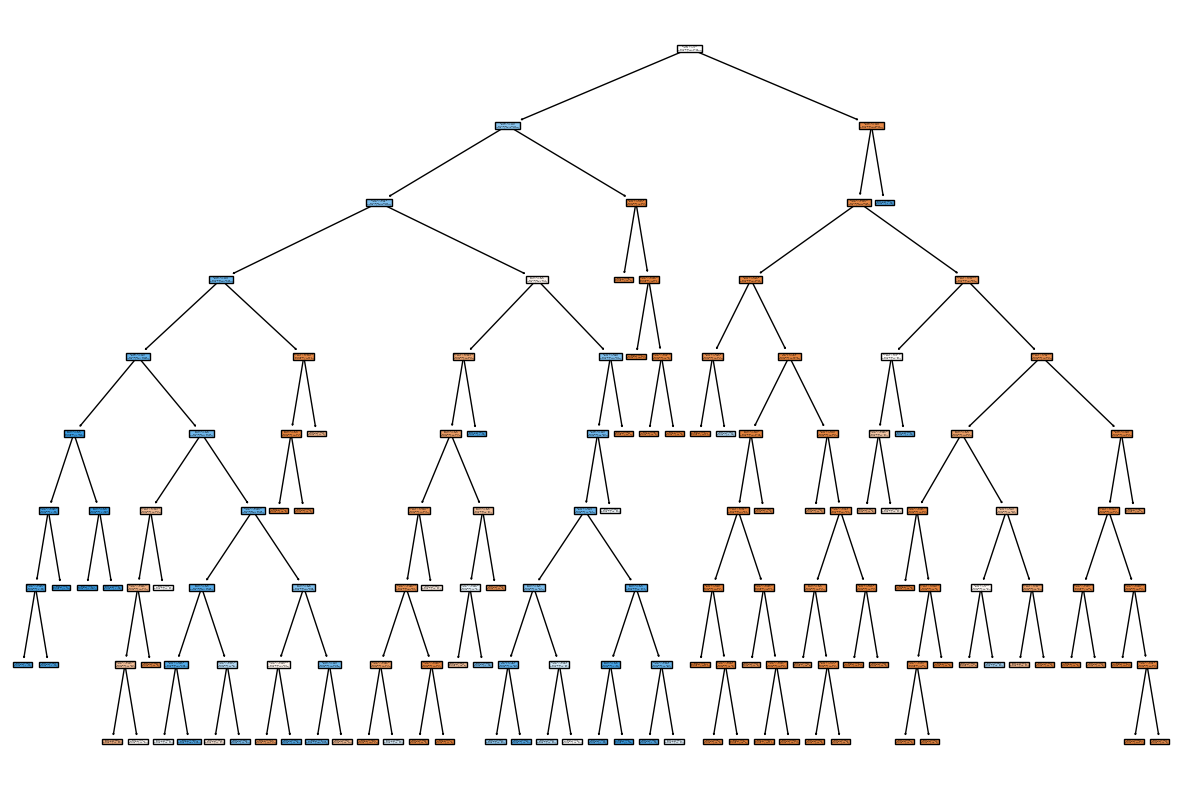

In [55]:
from sklearn import tree
import matplotlib.pyplot as plt # for data visualization
plt.figure(figsize=(15,10))
tree.plot_tree(dt_model, filled=True)

In [68]:
import pickle
path = "/content/sample_data/Models/dt_model.pkl"

# Save the model to a file
with open(path, 'wb') as file:
    pickle.dump(dt_model, file)

In [76]:
import pickle

record = "3,0,0,0,150,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0"
input_data = pd.DataFrame([list(map(float, record.split(',')))])
input_data.columns = ['reqId', 'numOfParams', 'numOfIds', 'reqLen', 'createInPath',
       'createInParams', 'addInPath', 'addInParams', 'setInPath',
       'setInParams', 'deleteInPath', 'deleteInParams', 'updateInPath',
       'updateInParams', 'removeInPath', 'removeInParams', 'friendInPath',
       'friendInParams', 'settingInPath', 'settingInParams', 'passwordInPath',
       'passwordInParams', 'tokenInPath', 'tokenInParams', 'changeInPath',
       'changeInParams', 'actionInPath', 'actionInParams', 'payInPath',
       'payInParams', 'loginInPath', 'loginInParams', 'logoutInPath',
       'logoutInParams', 'postInPath', 'postInParams', 'commentInPath',
       'commentInParams', 'followInPath', 'followInParams', 'subscribeInPath',
       'subscribeInParams', 'signInPath', 'signInParams', 'viewInPath',
       'viewInParams', 'isPUT', 'isDELETE', 'isPOST', 'isGET', 'isOPTIONS']
# Load the model from the file
with open(path, 'rb') as file:
    loaded_model = pickle.load(file)

# Now you can use the loaded model for predictions
predictions = loaded_model.predict(input_data)
print("Predictions: ", predictions)


Predictions:  [0]
